# Load data

## Read data

In [2]:
library(tidyverse)
library(Seurat)
library(sf)
library(anndata)
library(biomaRt)
library(Matrix)
library(BiocParallel)

set.seed(42)

In [3]:
### Read data
sc_meta <- read.csv('../sim_data/prox_assign/sc_meta.csv', row.names = 1)
meta <- sc_meta %>%
    mutate(radius = sqrt(area / pi))
head(meta)
mtx <- readRDS("../sim_data/prox_assign/mtx_500_genes.RDS")

,cell,x,y,elongation,area,srt_cell,radius
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,AAACCCAAGGTAAGGA-1,6589.351,18596.79,2.833,1390.0,Sham_21413,21.03451
2,AAACCCAAGTCCCAAT-1,6706.731,13677.54,4.263,1565.0,Sham_11856,22.31939
3,AAACCCACACCCTTGT-1,6332.787,13920.69,1.300,1403.0,Sham_11605,21.13265
4,AAACCCACACCGGAAA-1,5329.179,14816.21,33.140,517.4,Sham_11383,12.83330
5,AAACCCACAGACGGAT-1,12377.961,19690.29,1.846,6045.0,Sham_38551,43.86551
6,AAACCCACAGTCGGTC-1,13846.138,18517.05,5.112,378.9,Sham_39301,10.98215


# Simulate diffusion

In [4]:
## for every chunk
simulate_transcripts <- function(args) {
  mtx_chunk <- args[[1]]
  meta_chunk <- args[[2]]
  pct_out <- args[[3]]
  min_dist <- args[[4]]
  max_dist <- args[[5]]
  ## create df with transcript coordinates represented by the cell center
  transcripts <- data.frame()
  ## for every cell
  for (i in 1:dim(meta_chunk)[1]) {
    cell <- meta_chunk[i, ]
    cell_id <- cell$cell
    ## get expressed transcripts 
    ts <- mtx_chunk[which(mtx_chunk[, cell_id] > 0), cell_id]
    ## calculate transcripts outside and inside the cell
    ts_out <- round(ts * pct_out)
    ## calculate positions of the transcripts outside
    r <- sqrt(cell$area / pi)
    for (ts_name in names(ts_out)) {
      if (ts_out[ts_name] > 0) {
        for (j in 1:ts_out[ts_name]){
          ## generate random position for transcript given cell centroid
          ## calculate angle
          theta <- runif(1, 0, 2*pi)
          ## calculate distance
          d <- runif(1, r * min_dist, r * max_dist)
          x <- cell$x + d * cos(theta)
          y <- cell$y + d * sin(theta)
          ## add to dataframe
          transcripts <- rbind(transcripts, c(ts_name, x, y, cell_id))
        }
      }
    }
  }
  colnames(transcripts) <- c('gene', 'x', 'y', 'orig_cell')
  transcripts <- transcripts %>% 
    mutate(x = as.numeric(x), y = as.numeric(y))
  return(transcripts)
}

## intersect transcripts with cells
## for each cell, calculate intersection
interesect_transcripts <- function(args){
  meta_chunk <- args[[1]]
  transcripts <- args[[2]]
  mtx <- args[[3]]
  ## create empty mtx
  sim_mtx <- Matrix::sparseMatrix(dim(mtx)[1],
    dim(mtx)[2],
    x = 0
  )
  rownames(sim_mtx) <- rownames(mtx)
  colnames(sim_mtx) <- colnames(mtx)
  ## for each cell
  for (i in 1:dim(meta_chunk)[1]) {
    cell <- meta_chunk[i, ]
    ## intersect genes with cell
    ## filter genes near to speed the process
    near_transcripts <- transcripts %>% 
      mutate(distance = sqrt((x - cell$x)^2 + (y - cell$y)^2)) %>% 
      filter(distance <= cell$radius)
    ## if no genes are near, just skip
    if (dim(near_transcripts)[1] > 0) {
      genes_in <- near_transcripts$gene
      ## add the number of copies to the sim matrix
      count_genes_in <- table(genes_in)
      for (ts_name in names(count_genes_in)) {
        sim_mtx[ts_name, cell$cell] <- count_genes_in[ts_name]
      }
    }
  }
  return(sim_mtx)
}

In [5]:
simulate_ld_data <- function(mtx, meta, pct_out, min_dist, max_dist, n_cores) {
  ## populate matrix with transcripts that will not suffer diffusion
  nold_mtx <- mtx - round(mtx * pct_out)

  ## separate mtx and meta into chunks
  n_chunks <- 50
  cells_per_chunck <- ceiling(ncol(mtx) / n_chunks)
  ## mtx
  submatrices <- list()
  for (i in 1:(n_chunks - 1)) {
    start_col <- (i - 1) * cells_per_chunck + 1
    end_col <- i * cells_per_chunck
    submatrix <- mtx[, start_col:end_col]
    submatrices[[i]] <- submatrix
  }
  submatrices[[n_chunks]] <- mtx[, ((n_chunks - 1) * cells_per_chunck):ncol(mtx)]
  ## meta
  subdfs <- list()
  for (i in 1:(n_chunks - 1)) {
    start_col <- (i - 1) * cells_per_chunck + 1
    end_col <- i * cells_per_chunck
    subdf <- meta[start_col:end_col, ]
    subdfs[[i]] <- subdf
  }
  subdfs[[n_chunks]] <- meta[((n_chunks - 1) * cells_per_chunck):nrow(meta), ]

  ## join into list
  arguments <- lapply(1:n_chunks, FUN = function(i) {
    list(submatrices[[i]], subdfs[[i]], pct_out, min_dist, max_dist)
  })

  ## run parallelization
  bpparam <- MulticoreParam(workers = n_chunks)
  transcripts_list <- bplapply(arguments, simulate_transcripts, BPPARAM = bpparam)
  ## join dataframes
  transcripts <- bind_rows(transcripts_list)

  ## join into list
  arguments <- lapply(1:n_chunks, FUN = function(i) {
    list(subdfs[[i]], transcripts, mtx)
  })

  ## run parallelization
  bpparam <- MulticoreParam(workers = n_chunks)
  mtxs_list <- bplapply(arguments, interesect_transcripts, BPPARAM = bpparam)
  ## kachow
  sum_mtx <- Reduce("+", mtxs_list)

  ## sum ld genes with genes that did not ld
  ld_mtx <- nold_mtx + sum_mtx

  return(ld_mtx)
}

## Simulate datasets

### Percentage

In [13]:
pcts <- c(.01, seq(.02, .2, length.out = 10), .3, .4, .5)
for (pct in pcts){
  ld_mtx <- simulate_ld_data(mtx, meta, pct, 1, 2, 50)
  saveRDS(ld_mtx, paste0('../sim_data/prox_assign/ld_mtx_', 100*pct ,'pct_parallelized.RDS'))
}

In [7]:
# ld_mtx <- simulate_ld_data(mtx, meta, .05, 1, 2, 50)
# all(ld_mtx == mtx)
# saveRDS(ld_mtx, '../sim_data/prox_assign/ld_mtx_5pct_parallelized.RDS')

In [8]:
# ld_mtx <- simulate_ld_data(mtx, meta, .1, 1, 2, 50)
# all(ld_mtx == mtx)
# saveRDS(ld_mtx, '../sim_data/prox_assign/ld_mtx_10pct_parallelized.RDS')

In [9]:
# ld_mtx <- simulate_ld_data(mtx, meta, .2, 1, 2, 50)
# all(ld_mtx == mtx)
# saveRDS(ld_mtx, '../sim_data/prox_assign/ld_mtx_20pct_parallelized.RDS')

In [10]:
# ld_mtx <- simulate_ld_data(mtx, meta, .5, 1, 2, 50)
# all(ld_mtx == mtx)
# saveRDS(ld_mtx, '../sim_data/prox_assign/ld_mtx_50pct_parallelized.RDS')

Check if code is actually doing something.

In [11]:
## get stats for original mtx
paste(mean(mtx), median(mtx), max(mtx), min(mtx), sum(mtx > 0), sep = '    ')

[1] "0.390971879712588    0    2976    0    344070"

In [14]:
## stats for 1 pct
ld_mtx <- readRDS('../sim_data/prox_assign/ld_mtx_6pct_parallelized.RDS')
paste(mean(ld_mtx), median(ld_mtx), max(ld_mtx), min(ld_mtx),
  sum(ld_mtx > 0), sep = '    ')

[1] "0.38582737514415    0    2797    0    352407"

In [17]:
max(mtx) * .94

[1] 2797.44

The transcript with the highest count in one cell actually lost 5% of the transcrips, as expected. However, the average count increased and the number of zero counts was reduced, probably due to double counting.

In [18]:
## stats per cell
counts_per_cell <- colSums(mtx)
paste(mean(counts_per_cell), median(counts_per_cell), 
  max(counts_per_cell), min(counts_per_cell),
  sum(counts_per_cell > 0), sep = '    ')

[1] "195.485939856294    43    6584    1    11273"

In [19]:
## sim data
counts_per_cell <- colSums(ld_mtx)
paste(mean(counts_per_cell), median(counts_per_cell), 
  max(counts_per_cell), min(counts_per_cell),
  sum(counts_per_cell > 0), sep = '    ')

[1] "192.913687572075    46    6188    1    11273"

Same results as before.

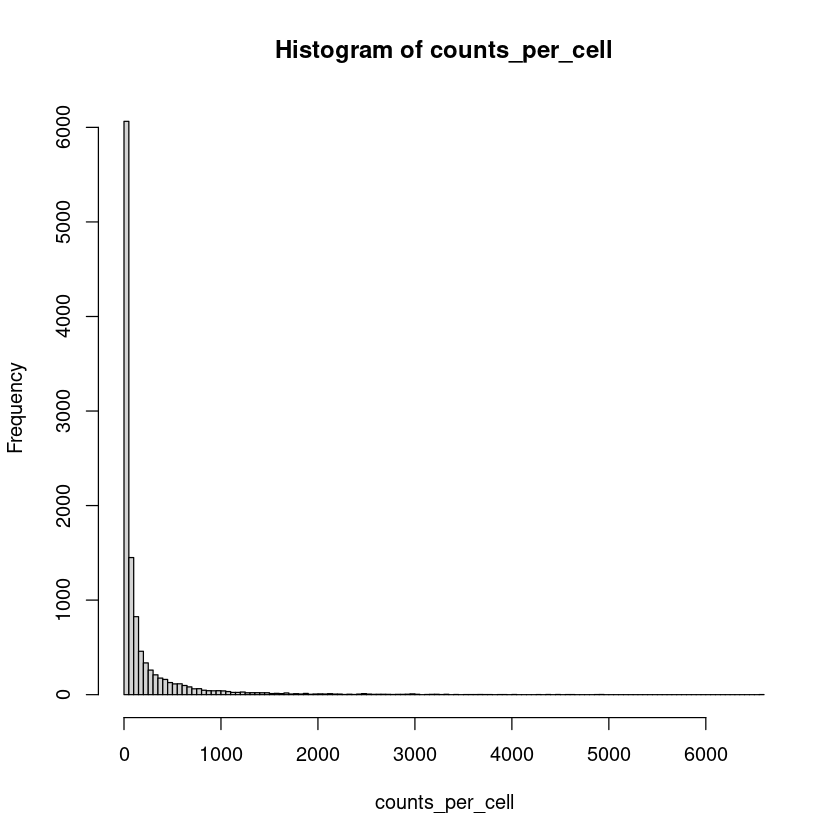

In [20]:
counts_per_cell <- colSums(mtx)
hist(counts_per_cell, breaks = 100)

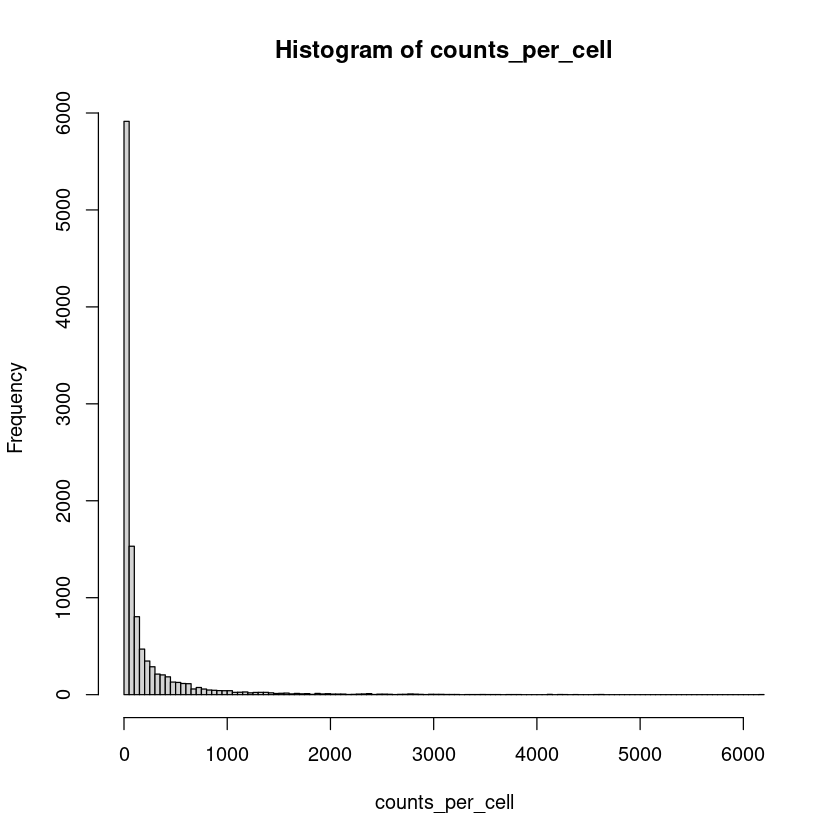

In [21]:
counts_per_cell <- colSums(ld_mtx)
hist(counts_per_cell, breaks = 100)

### Max distance

In [27]:
maxs <- c(1.01, 1.05, seq(1.1, 2, length.out = 10), 3, 4, 5, 10)
for (max in maxs){
  ld_mtx <- simulate_ld_data(mtx, meta, .2, 1, max, 50)
  saveRDS(ld_mtx, paste0('../sim_data/prox_assign/ld_mtx_', gsub("\\.", "p", max) ,'max_parallelized.RDS'))
}

In [ ]:
# ld_mtx <- simulate_ld_data(mtx, meta, .2, 1, 1.1, 50)
# all(ld_mtx == mtx)
# saveRDS(ld_mtx, '../sim_data/prox_assign/ld_mtx_1p1max_parallelized.RDS')

[1] FALSE

In [ ]:
# ld_mtx <- simulate_ld_data(mtx, meta, .2, 1, 1.5, 50)
# all(ld_mtx == mtx)
# saveRDS(ld_mtx, '../sim_data/prox_assign/ld_mtx_1p5max_parallelized.RDS')

[1] FALSE

In [ ]:
# ld_mtx <- simulate_ld_data(mtx, meta, .2, 1, 2, 50)
# all(ld_mtx == mtx)
# saveRDS(ld_mtx, '../sim_data/prox_assign/ld_mtx_2max_parallelized.RDS')

[1] FALSE

In [ ]:
# ld_mtx <- simulate_ld_data(mtx, meta, .2, 1, 5, 50)
# all(ld_mtx == mtx)
# saveRDS(ld_mtx, '../sim_data/prox_assign/ld_mtx_5max_parallelized.RDS')

[1] FALSE

In [ ]:
# ld_mtx <- simulate_ld_data(mtx, meta, .2, 1, 25, 50)
# all(ld_mtx == mtx)
# saveRDS(ld_mtx, '../sim_data/prox_assign/ld_mtx_25max_parallelized.RDS')

[1] FALSE